In [47]:
import requests
import pandas as pd
import requests
import json

from typing import List, Any, Dict
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

#### Data import

In [2]:
api_link = "https://api.elhub.no/energy-data/v0/consumption-groups"

response = requests.get(api_link)
response.raise_for_status()

data = response.json()

consumption_groups = [i["id"] for i in data["data"]]

print(consumption_groups)

['household', 'cabin', 'primary', 'secondary', 'tertiary', 'industry', 'private', 'business', '*']


In [48]:
from datetime import timedelta


def get_consumption_data(area: str, 
                         start_time: datetime = datetime(year=2023, month=1, day=1), 
                         end_time: datetime = datetime(year=2023, month=3, day=1)
                         ) -> List[Dict[str, Any]]:
    api_link = "https://api.elhub.no/energy-data/v0/price-areas"

    result = []
    while start_time < end_time:
        # API only allows for time intervals of max 1 month.
        temp_end = min(start_time + timedelta(weeks=4), end_time)

        params = {
            "dataset": "CONSUMPTION_PER_GROUP_MBA_HOUR",
            "startDate": f"{start_time.isoformat()}+02:00",
            "endDate": f"{temp_end.isoformat()}+02:00",
        }

        response = requests.get(f"{api_link}/{area}", params=params)
        response.raise_for_status()

        result.extend(response.json()["data"][0]["attributes"]["consumptionPerGroupMbaHour"])
        start_time = temp_end

    return result

data = get_consumption_data("NO5", start_time=datetime(year=2024, month=1, day=1), end_time=datetime(year=2025, month=1, day=1))

In [ ]:
consumption_df = pd.DataFrame(data)
consumption_df["startTime"] = pd.to_datetime(consumption_df["startTime"], utc=True)

# sort usage by start time and consumption group
consumption_by_group = consumption_df.pivot_table(
    index="startTime",
    columns="consumptionGroup",
    values="quantityKwh"
    ).sort_index()

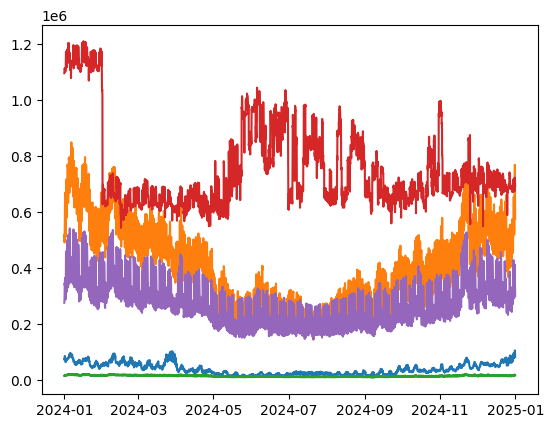

In [50]:
plt.plot(consumption_by_group)

#### 1. Utvikling i strømforbruk
Hvordan har strømforbruket i **NO5** utviklet seg de siste årene blant de forskjellige forbrukergruppene?  
Har forbruksmønsteret endret seg siden 2021?